### Installing dependencies

In [19]:
# region For data processing & plotting:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy
from scipy.signal import detrend

# For ML:
import time as timer  # for timing code cells.
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector  # For sequential feature sel.
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import make_pipeline  # for grid-search over parameters pipeline.


# Classifiers for CPU based computing:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron

# Only for GPU based computing:
#from cuml.svm import SVC
#from cuml.neighbors import KNeighborsClassifier
#from cuml.ensemble import RandomForestClassifier
#from cuml.linear_model import LogisticRegression

# endregion

### Loading Data

In [20]:
s1_1 = pd.read_csv('data/11.csv', header=None)  # first subject, sensor 1
ch1 = s1_1.iloc[:, 1]
ch2 = s1_1.iloc[:, 2]
r1_1_ch1 = (-ch1 * 100) / (ch1 - 1)  # channel one (normal breathing)

r1_1_ch1_sm = r1_1_ch1 - np.mean(r1_1_ch1)
r1_1_ch1_dt = detrend(r1_1_ch1)

r1_1_ch2 = (-ch2 * 100) / (ch2 - 1)  # channel two (normal breathing) [This channel was not used]
time = np.arange(0, .015 * len(r1_1_ch1), .015)  # 15 ms per time-point

s1_2 = pd.read_csv('data/12.csv', header=None)  # first subject, sensor 2
ch1 = s1_2.iloc[:, 1]
ch2 = s1_2.iloc[:, 2]

r1_2_ch1 = (-ch1 * 100) / (ch1 - 1)  # channel one (coughing)

r1_2_ch1_sm = r1_2_ch1 - np.mean(r1_2_ch1)
r1_2_ch1_dt = detrend(r1_2_ch1)

r1_2_ch2 = (-ch2 * 100) / (ch2 - 1)  # channel two (coughing) [This channel was not used]

s2_1 = pd.read_csv('data/21.csv', header=None)
ch1 = s2_1.iloc[:, 1]
ch2 = s2_1.iloc[:, 2]
r2_1_ch1 = (-ch1 * 100) / (ch1 - 1)

r2_1_ch1_sm = r2_1_ch1 - np.mean(r2_1_ch1)
r2_1_ch1_dt = detrend(r2_1_ch1)

r2_1_ch2 = (-ch2 * 100) / (ch2 - 1)

s2_2 = pd.read_csv('data/22.csv', header=None)
ch1 = s2_2.iloc[:, 1]
ch2 = s2_2.iloc[:, 2]
r2_2_ch1 = (-ch1 * 100) / (ch1 - 1)

r2_2_ch1_sm = r2_2_ch1 - np.mean(r2_2_ch1)
r2_2_ch1_dt = detrend(r2_2_ch1)

r2_2_ch2 = (-ch2 * 100) / (ch2 - 1)

s3_1 = pd.read_csv('data/41.csv', header=None)
ch1 = s3_1.iloc[:, 1]
ch2 = s3_1.iloc[:, 2]
r3_1_ch1 = (-ch1 * 100) / (ch1 - 1)

r3_1_ch1_sm = r3_1_ch1 - np.mean(r3_1_ch1)
r3_1_ch1_dt = detrend(r3_1_ch1)

r3_1_ch2 = (-ch2 * 100) / (ch2 - 1)

s3_2 = pd.read_csv('data/42.csv', header=None)
ch1 = s3_2.iloc[:, 1]
ch2 = s3_2.iloc[:, 2]
r3_2_ch1 = (-ch1 * 100) / (ch1 - 1)

r3_2_ch1_sm = r3_2_ch1 - np.mean(r3_2_ch1)
r3_2_ch1_dt = detrend(r3_2_ch1)

r3_2_ch2 = (-ch2 * 100) / (ch2 - 1)
# endregion

### Plotting Data

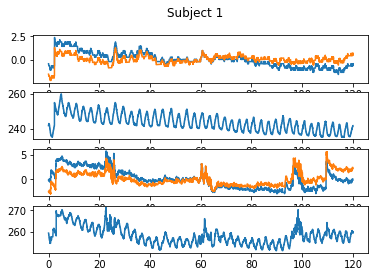

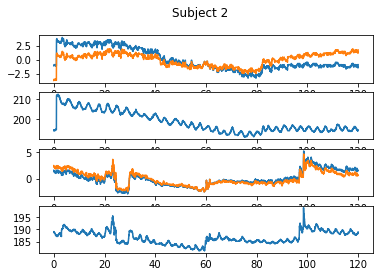

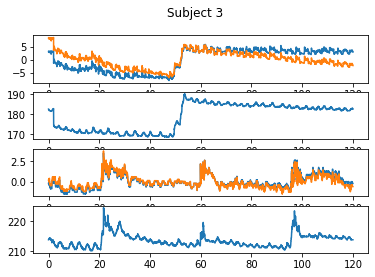

In [21]:
fig, axs = plt.subplots(4, 1)
fig.suptitle('Subject 1')
axs[0].plot(time, r1_1_ch1_sm)
axs[0].plot(time, r1_1_ch1_dt)
axs[1].plot(time, r1_1_ch2)
axs[2].plot(time, r1_2_ch1_sm)
axs[2].plot(time, r1_2_ch1_dt)
axs[3].plot(time, r1_2_ch2)
plt.show()

fig, axs = plt.subplots(4, 1)
fig.suptitle('Subject 2')
axs[0].plot(time, r2_1_ch1_sm)
axs[0].plot(time, r2_1_ch1_dt)
axs[1].plot(time, r2_1_ch2)
axs[2].plot(time, r2_2_ch1_sm)
axs[2].plot(time, r2_2_ch1_dt)
axs[3].plot(time, r2_2_ch2)
plt.show()

fig, axs = plt.subplots(4, 1)
fig.suptitle('Subject 3')
axs[0].plot(time, r3_1_ch1_sm)
axs[0].plot(time, r3_1_ch1_dt)
axs[1].plot(time, r3_1_ch2)
axs[2].plot(time, r3_2_ch1_sm)
axs[2].plot(time, r3_2_ch1_dt)
axs[3].plot(time, r3_2_ch2)
plt.show()

### Creating labels for coughing events

In [6]:
label1 = (time > 20) * (time < 25)
label2 = (time > 60) * (time < 65)
label3 = (time > 95) * (time < 100)
label_c = label1 + label2 + label3
label_c = np.int32(label_c)
# Turn into Dataframe
label_c = pd.DataFrame(label_c)
label_c = label_c.iloc[:, 0]

# Label for channels with no coughing (all 0's):
label_nc = np.zeros(len(label_c))
label_nc = pd.DataFrame(label_nc)
label_nc = label_nc.iloc[:, 0]

### Plotting labeled data

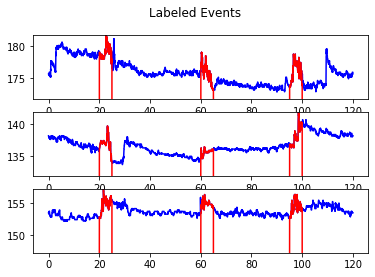

In [7]:

# Plot subjects with red labeled as cough:
labels = ['r1_2_ch1', 'r2_2_ch1', 'r3_2_ch1']
fig, axs = plt.subplots(3, 1)
fig.suptitle("Labeled Events")
for i in range(3):
    data = locals()[labels[i]]
    axs[i].plot(time, data, 'b')
    axs[i].plot(time, data * label_c, 'r')
    axs[i].set_ylim([np.max(data)-10, np.max(data)])
plt.show()

In [10]:
labels[2]

'r3_2_ch1'

In [11]:
locals()[labels[2]]









0       153.507916
1       153.507916
2       153.507916
3       153.507916
4       153.507916
           ...    
7995    153.507916
7996    153.507916
7997    153.507916
7998    153.507916
7999    153.507916
Name: 1, Length: 8000, dtype: float64